Comments

In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import logging

# Create and configure logger
logging.basicConfig(
	filename = "debug.log",
	format = "%(asctime)s [%(levelname)s] %(message)s",
	filemode = 'w')

# Create a custom logger to prevent debugging info from imported modules
logger = logging.getLogger(__name__)

# Setting the threshold of logger to DEBUG
logger.setLevel(logging.DEBUG)

# Create an empty list to hold the data
data = []

# Loop over all the pages in the website
for page in range(1420):

	# Create the url for each page
	url = 'https://www.standvirtual.com/carros/usados?page={}'.format(page)

	# Get the page contents
	r = requests.get(url)

	# Scrape the page contents
	soup = BeautifulSoup(r.content, 'html.parser')

	# Find the ads
	ads = soup.find_all("article", {"class": "ooa-yca59n eszxync0"})

	# Loop through each ad to scrape the relevant data
	for i, ad in enumerate(ads):

		# Give a summary of the ads found in each page
		print(f'Page: {page} - ad found: {i}/{len(ads)}', end='\r')

		try:
			# Get the ad attributes
			title = ad.find("h1", {"class": "eszxync9 ooa-1ed90th er34gjf0"}).text
			cc_hp = ad.find("p", {"class": "eszxync10 ooa-1tku07r er34gjf0"}).text
			kms, fuel, gear, year = [attr.text for attr in ad.find_all("dd", {"class": "ooa-1omlbtp eszxync13"})]
			loc = ad.find("dd", {"class": "ooa-1jb4k0u eszxync15"}).text
			price = ad.find("h3", {"class": "eszxync16 ooa-1n2paoq er34gjf0"}).text

			# Append the attributes to the data list as a dictionary 
			data.append({
				'TITLE': title,
				'CC_HP': cc_hp,
				'KMS': kms,
				'FUEL': fuel,
				'GEAR': gear,
				'YEAR': year,
				'LOC': loc,
				'PRICE': price,
			})

			# Write to the logger
			logger.info(f'Sucessfully scraped page: {page} - ad found: {i}/{len(ads)}')

		except Exception as err:
			logger.error(f'Failed to scrape page: {page} - ad found: {i}/{len(ads)}')

# Save the data to an excel file
df = pd.DataFrame(data)
df.to_excel('RAW_DATA.xlsx', index=False)

KeyboardInterrupt: 

Comments

In [1]:
import pandas as pd
import numpy as np

# Import the data
df = pd.read_excel('data/RAW_DATA.xlsx', nrows=100000)

# Start by removing duplicates
df = df.drop_duplicates()

# Clean the kilometers and price columns
df['KMS'] = df['KMS'].str.replace('km| ', '', regex=True).astype(int)
df['PRICE'] = df['PRICE'].str.replace(' ', '').astype(int)

# Get the cubic centimeters and the horsepower
df['CC'] = None
df['HP'] = None
for index, row in df.iterrows():
    res = row['CC_HP'].split(' • ')
    if len(res) == 2:
        cc, hp = res
        df.loc[index, 'CC'] = cc.replace('cm3', '').replace(' ', '')
        df.loc[index, 'HP'] = hp.replace('cv', '').replace(' ', '')
    elif res[0].endswith(' cv'):
        df.loc[index, 'CC'] = None
        df.loc[index, 'HP'] = res[0].replace('cv', '').replace(' ', '')
    elif res[0].endswith('cm3'):
        df.loc[index, 'CC'] = res[0].replace('cm3', '').replace(' ', '')
        df.loc[index, 'HP'] = None
df['CC'] = df['CC'].fillna(np.nan).astype('Int64')
df['HP'] = df['HP'].astype(int)

# Alternatively, use regular expressions
# df['CC'] = df['CC_HP'].str.extract('^(.*) cm3')
# df['CC'] = df['CC'].str.replace(' ', '')
# df['HP'] = df['CC_HP'].str.extract('(.*) cv')
# df['HP'] = df['HP'].str.replace(' ', '')

df['DISTRICT'] = None
for index, row in df.iterrows():
    res = row['LOC'].split('(')
    df.loc[index, 'DISTRICT'] = res[-1].replace(')', '')

df['BRAND'] = df['TITLE'].str.split().str.get(0)

# Alternatively, use regular expressions
# df['DISTRICT'] = df['LOC'].str.extract('\((.*)\)$')

# Drop undesired columns
df = df.drop(columns=['CC_HP', 'TITLE', 'LOC'])

# Drop NA rows
df = df.dropna()

# Print the first five rows
print(df.head())

# Save to excel
df.to_excel('data/CLEAN_DATA.xlsx', index=False)

     KMS      FUEL        GEAR  YEAR   PRICE    CC   HP DISTRICT  \
0   5545  Gasolina  Automática  2021  650000  6496  800   Lisboa   
1  67094    Diesel  Automática  2019   26990  1995  150    Braga   
2  55960    Diesel  Automática  2014   19500  1461   90  Setúbal   
3  41818    Diesel  Automática  2016   14900  1560  120  Setúbal   
4     10       GPL      Manual  2023   25500   999  101    Porto   

           BRAND  
0        Ferrari  
1            BMW  
2  Mercedes-Benz  
3        Citroën  
4          Dacia  


Comments

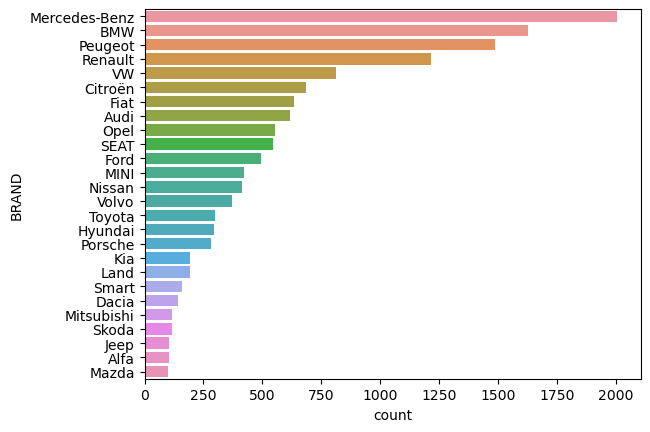

TypeError: PairGrid.__init__() got an unexpected keyword argument 'plot_kws'

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the clean data
df = pd.read_excel('data/CLEAN_DATA.xlsx')

temp = df[df['BRAND'].map(df['BRAND'].value_counts()) > 100]

sns.countplot(
    data = temp, 
    order = temp['BRAND'].value_counts().index,
    y='BRAND')
plt.show()

# Show a grid plot of numerical data
g = sns.PairGrid(temp, hue='GEAR')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, s=1)
g.add_legend()
plt.show()